## Expirementation with XGBoost to detect Automatically Generated Domains <b>
ML Model to detect Domain Generation Algorithm (DGA) generated Domains vs Legit domains.

In [5]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import tldextract
import sklearn.feature_extraction

from numpy import sort
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

plt.rcParams['figure.figsize'] = (14.0, 5.0)
plt.rcParams['axes.grid'] = True

sns.set()
%matplotlib inline


In [6]:
# This is the Alexa 100k domain list, we're not using the 1 Million just for speed reasons. Results
# for the Alexa 1M are given at the bottom of the notebook.
alexa_dataframe = pd.read_csv('alexa_100k.csv', names=['rank','uri'], header=None, encoding='utf-8')
alexa_dataframe.head()

,rank,uri
0,1,facebook.com
1,2,google.com
2,3,youtube.com
3,4,yahoo.com
4,5,baidu.com


In [7]:
def domain_extract(uri):
    ext = tldextract.extract(uri)
    if (ext.suffix):
        return ext.domain
    return np.nan
        
alexa_dataframe['domain'] = [ domain_extract(uri) for uri in alexa_dataframe['uri']]
del alexa_dataframe['rank']
del alexa_dataframe['uri']
print(alexa_dataframe.shape)
alexa_dataframe.head()

(100000, 1)


,domain
0,facebook
1,google
2,youtube
3,yahoo
4,baidu


In [8]:
alexa_dataframe = alexa_dataframe.dropna()
alexa_dataframe = alexa_dataframe.drop_duplicates()
alexa_dataframe['class'] = 'legit'
alexa_dataframe = alexa_dataframe.reindex(np.random.permutation(alexa_dataframe.index))
alexa_dataframe.head()

,domain,class
90296,bricorama,legit
25950,techshali,legit
88924,secwh,legit
40348,hizlireklam,legit
64190,ocholeguas,legit


In [9]:
alexa_dataframe.shape

(91376, 2)

In [10]:
dga_dataframe = pd.read_csv('dga_domains.txt', names=['raw_domain'], header=None, encoding='utf-8')
dga_dataframe['domain'] = dga_dataframe.applymap(lambda x: x.split('.')[0].strip().lower())
del dga_dataframe['raw_domain']
dga_dataframe = dga_dataframe.dropna()
dga_dataframe = dga_dataframe.drop_duplicates()
dga_dataframe['class'] = 'dga'
print(dga_dataframe.shape)
dga_dataframe.head()

(2664, 2)


,domain,class
0,04055051be412eea5a61b7da8438be3d,dga
1,1cb8a5f36f,dga
2,30acd347397c34fc273e996b22951002,dga
3,336c986a284e2b3bc0f69f949cb437cb,dga
5,40a43e61e56a5c218cf6c22aca27f7ee,dga


In [11]:
all_domains = pd.concat([alexa_dataframe, dga_dataframe], ignore_index=True)
all_domains['length'] = [len(x) for x in all_domains['domain']]

all_domains.head()

,domain,class,length
0,bricorama,legit,9
1,techshali,legit,9
2,secwh,legit,5
3,hizlireklam,legit,11
4,ocholeguas,legit,10


http://rosettacode.org/wiki/Entropy#Python:_More_succinct_version

In [12]:
import math
from collections import Counter
 
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

In [13]:

all_domains['entropy'] = [entropy(x) for x in all_domains['domain']]

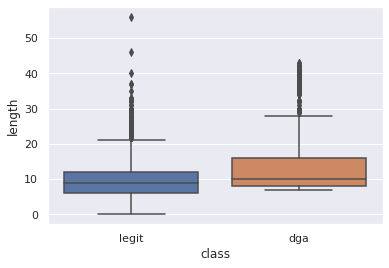

In [14]:
sns.boxplot(x=all_domains['class'],y=all_domains['length'])

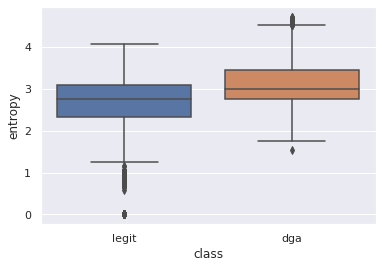

In [15]:
sns.boxplot(x=all_domains['class'],y=all_domains['entropy'])

In [16]:
X = all_domains[['length', 'entropy']]
Y = all_domains[['class']]

/home/sandeepnl/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sandeepnl/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
[0.4128456 0.5871544]


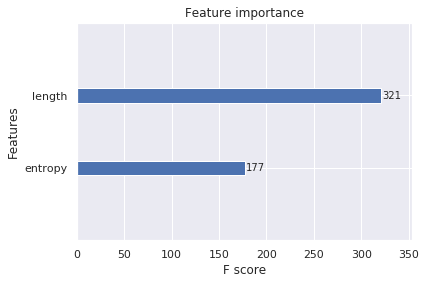

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

# fit model to training data
model = XGBClassifier()
model.fit(X_train, y_train)
print(model)
print(model.feature_importances_)

ax = plot_importance(model)
fig = ax.figure
plt.show(fig)

In [18]:
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.68%


In [19]:

alexa_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-4, max_df=1.0)
counts_matrix = alexa_vc.fit_transform(alexa_dataframe['domain'])
alexa_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = alexa_vc.get_feature_names()

In [20]:
word_dataframe = pd.read_csv('words.txt', names=['word'], header=None, dtype={'word': np.str}, encoding='utf-8')

word_dataframe = word_dataframe[word_dataframe['word'].map(lambda x: str(x).isalpha())]
word_dataframe = word_dataframe.applymap(lambda x: str(x).strip().lower())
word_dataframe = word_dataframe.dropna()
word_dataframe = word_dataframe.drop_duplicates()
# word_dataframe.head(10)

In [21]:
dict_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-5, max_df=1.0)
counts_matrix = dict_vc.fit_transform(word_dataframe['word'])
dict_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = dict_vc.get_feature_names()

In [22]:
all_domains['alexa_grams']= alexa_counts * alexa_vc.transform(all_domains['domain']).T 
all_domains['word_grams']= dict_counts * dict_vc.transform(all_domains['domain']).T 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
[0.551759   0.2333764  0.18155824 0.03330632]


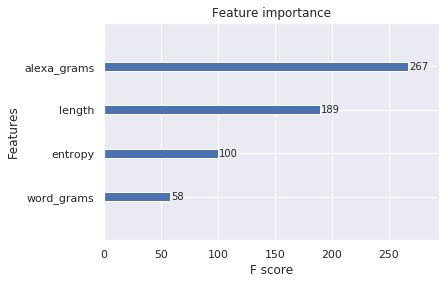

In [23]:
X = all_domains[['length', 'entropy','alexa_grams','word_grams']]
# Y = all_domains[['class']]
Y = np.array(all_domains['class'].tolist())
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

model = XGBClassifier()
model.fit(X_train, y_train)
print(model)
print(model.feature_importances_)

ax = plot_importance(model)
fig = ax.figure
plt.show(fig)

In [24]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.26%


In [25]:
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.033, n=4, Accuracy: 99.26%
Thresh=0.182, n=3, Accuracy: 99.24%
Thresh=0.233, n=2, Accuracy: 97.68%
Thresh=0.552, n=1, Accuracy: 97.56%


In [26]:
# select features using best threshold 
selection = SelectFromModel(model, threshold=0.035, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier()
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9923632145388929


In [43]:
select_X_test

array([[ 5.        ,  2.32192809,  5.67383157],
       [14.        ,  3.32486296, 58.32152397],
       [ 7.        ,  2.52164064, 19.19782198],
       ...,
       [ 8.        ,  2.75      , 21.22405477],
       [ 9.        ,  2.94770278, 19.26075784],
       [11.        ,  2.91397707, 35.87560929]])

In [53]:
def test_it(domain):
    _alexa_match = alexa_counts * alexa_vc.transform([domain]).T 
    _dict_match = dict_counts * dict_vc.transform([domain]).T
    _X = [len(domain), entropy(domain), _alexa_match, _dict_match]
    X_test_transformed = selection.transform(X_test)
    print(X_test_transformed)
    predicted = selection_model.predict(X_test_transformed)
    print(domain,predicted )
    #     print('%s : %s' % (domain, selection_model.predict([_X])))

        # Examples (feel free to change these and see the results!)
# test_it('google')
# test_it('google88')
# test_it('facebook')
# test_it('1cb8a5f36f')
# test_it('pterodactylfarts')
# test_it('ptes9dro-dwacty2lfa5rrts')
# test_it('beyonce')
# test_it('bey666on4ce')
# test_it('supersexy')
# test_it('yourmomissohotinthesummertime')
test_it('04055051be412eea5a61b7da8438be3d')
# test_it('clicksecurity')


[[ 5.          2.32192809  5.67383157]
 [14.          3.32486296 58.32152397]
 [ 7.          2.52164064 19.19782198]
 ...
 [ 8.          2.75       21.22405477]
 [ 9.          2.94770278 19.26075784]
 [11.          2.91397707 35.87560929]]
04055051be412eea5a61b7da8438be3d ['legit' 'legit' 'legit' ... 'legit' 'legit' 'legit']
